In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
! pip install pytorch_lightning

In [ ]:
! pip install optuna

In [31]:
import optuna
import numpy as np

def objective(trial):
  params = {
      "num_layers" : trial.suggest_int("num_layer",1,7),
      "hidden_size": trial.suggest_int("hidden_size",16,2048),
      "dropout" : trial.suggest_uniform("dropout",0.1,0.7),
      "learning_rate" : trial.suggest_loguniform("learning_rate",1e-6,1e-3)
  }
  model = light_MNIST_classifier(
      nfeatures = 784,
      ntargets = 10,
      nlayers = params["num_layers"],
      hidden_size = params["hidden_size"],
      dropout = params["dropout"]
  )
  trainer = pl.Trainer(max_epochs = 3, gpus=1)
  all_losses = []
  for f in range(5):
    temp_loss = trainer.fit(model)
    all_losses.append(temp_loss)
  return np.mean(all_losses)

### Lightning Magic
1. Model
2. Optmizer
3. Data
4. Training loop
5. Validation loop

In [32]:
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import random_split
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor
from torch import nn, optim

class light_MNIST_classifier(pl.LightningModule):
  def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
    super().__init__()
    layers = []
    for _ in range(nlayers):
      if len(layers) == 0:
        layers.append(nn.Linear(nfeatures, hidden_size))
        layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU())
    else:
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU())  
    layers.append(nn.Linear(hidden_size, ntargets))
    layers.append(nn.LogSoftmax(dim=1))
    self.model = nn.Sequential(*layers)
    self.criterion = nn.NLLLoss()
    self.transform = Compose([ToTensor(),])

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    optimizer = optim.SGD(self.parameters(), lr=0.0002, momentum=0.9)
    return optimizer

  def training_step(self,batch, batch_idx):
    images,labels = batch
    images = images.view(images.shape[0], -1)
    output = self(images)
    loss = self.criterion(output, labels)

    acc = accuracy(output, labels)
    prog_bar = {'train_acc': acc}
    return {'loss': loss,'progress_bar':prog_bar}
    #return loss

  def validation_step(self,batch, batch_idx):
    results = self.training_step(batch, batch_idx)
    results['progress_bar']['val_acc'] = results['progress_var']['train_acc']
    del results['progress_var']['train_acc']
    return results

  
  def validation_epoch_end(self, val_step_outputs):
    #[result1, result2, result3]
    avg_validation_loss = torch.tensor([x['loss'] for x in val_step_outputs]).mean()
    avg_validation_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_step_outputs]).mean()

    progress_bar1 = {'avg_val': avg_validation_acc}
    return {'val_loss':avg_validation_loss, 'progress_bar':pbar}

  def prepare_data(self):
     # only happens at only one CPU
     datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform = self.transform)

  # def setup(self,step):
  #   dataset= datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform = self.transform)
  #   self.train,self.val = random_split(dataset,[55000,5000])

  def train_dataloader(self):
    dataset= datasets.MNIST('PATH_TO_STORE_TRAINSET', download=False, train=True, transform = self.transform)
    self.train,self.val = random_split(dataset,[55000,5000])
    train_loader = torch.utils.data.DataLoader(self.train, batch_size=64, shuffle=True)
    return train_loader

  # def val_dataloader(self):
  #   val_loader = torch.utils.data.DataLoader(self.val, batch_size=64, shuffle=False)
  #   return val_loader

In [33]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))    

[I 2020-11-13 03:16:33,577] A new study created in memory with name: no-name-1c4600de-da9c-4d8e-b163-94e029f3f40e
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

you defined a validation_step but have no val_dataloader. Skipping validation loop


  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 2 M   
1 | criterion | NLLLoss    | 0     


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)


  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 2 M   
1 | criterion | NLLLoss    | 0     


[W 2020-11-13 03:17:10,806] Trial 0 failed because of the following error: TypeError("'Subset' object is not callable",)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/optuna/_optimize.py", line 189, in _run_trial
    value = func(trial)
  File "<ipython-input-31-a28aeedaff3e>", line 21, in objective
    temp_loss = trainer.fit(model)
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/trainer.py", line 444, in fit
    results = self.accelerator_backend.train()
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/accelerators/gpu_accelerator.py", line 63, in train
    results = self.train_or_test()
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/accelerators/accelerator.py", line 74, in train_or_test
    results = self.trainer.train()
  File "/usr/local/lib/python3.6/dist-packages/pytorch_lightning/trainer/trainer.py", line 472, in train
    model.train()
TypeError: 'Subset' object is not callable


TypeError: ignored

In [25]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 1


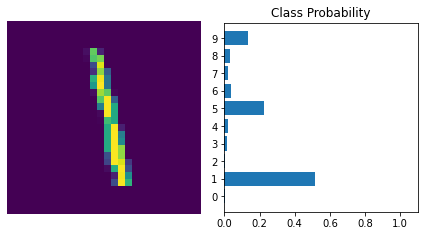

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.6867


In [ ]:
torch.save(model, './my_mnist_model.pt') 